Generating Features

In [47]:
class SmilesFeatureGenerator:
    """Extract chemical features from smiles"""
    def __init__(self, smiles_list, normalize=False):
        self.smiles_list = smiles_list
        self.normalize = normalize

    def _get_features_list(self):
        """Get feature names"""
        from descriptastorus.descriptors import rdNormalizedDescriptors
        generator = rdNormalizedDescriptors.RDKit2DNormalized()
        features_list = []
        for pair in generator.columns:
            features_list.append(pair[0])
        return features_list
    
    def get_features_dataframe(self):
        """Get features from smiles and return as a dataframe object"""
        from chemprop.features.features_generators import rdkit_2d_features_generator, rdkit_2d_normalized_features_generator
        import pandas as pd
        import numpy as np
        features_generator = rdkit_2d_normalized_features_generator if self.normalize else rdkit_2d_features_generator
        gen_cols = self._get_features_list()
        features = list(map(features_generator, self.smiles_list))
        return pd.DataFrame(data=np.array(features).reshape(len(features), -1), columns=gen_cols)

Importing & Splitting Dataset

In [50]:
from sklearn.model_selection import cross_validate
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
feature_extracted = pd.read_csv('D1_filtered_features.csv').drop('Unnamed: 0', axis=1)
feature_extracted.head()

In [52]:
# split data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature_extracted.iloc[:, :-1], feature_extracted.iloc[:, -1], test_size=0.1, random_state=42)

In [53]:
# validate ratio between training and testing set
X_test.shape[0]/X_train.shape[0]

0.11114722131946701

### KNN Regressor

In [54]:
# create knn regressor instance
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
knnreg = KNeighborsRegressor()

In [55]:
def calculate_metrics_knnreg(x, y, estimator, kneighbors:list):
    """
    This function performs fitting and predicting, then measuring r^2 and rmse metrics for each 
    n_neighbors.
    """
    from sklearn.metrics import r2_score, mean_squared_error
    import pandas as pd
    import numpy as np
    performance = {'r2': [], 'rmse': [], 'label':[]}
    for n in kneighbors:
        estimator.set_params(n_neighbors=n)
        estimator.fit(np.array(X_train), np.array(y_train))
        y_pred = estimator.predict(x)
        performance['r2'] += [r2_score(y, y_pred)]
        performance['rmse'] += [mean_squared_error(y, y_pred) ** (1/2)]
        performance['label'] += [f"n_{n}"]
    
    perf_df = pd.DataFrame(performance)
    perf_df.set_index('label', inplace=True)
    return perf_df

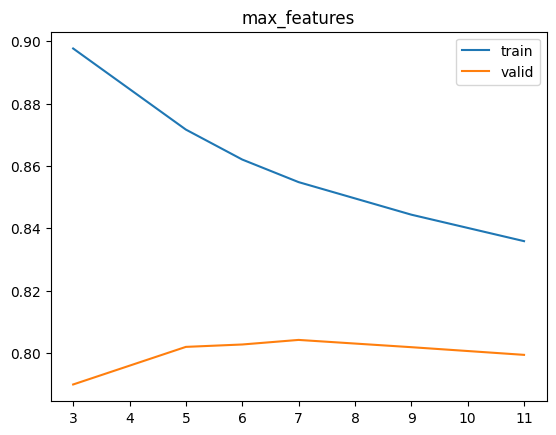

7

In [56]:
params = [3, 5, 6, 7, 9, 11]
train = []
valid = []

for par in params:
    result = cross_validate(KNeighborsRegressor(n_neighbors=par), 
                            X_train, y_train, cv=10, scoring = 'r2', return_train_score=True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot(x = params, y = valid, label = 'valid')
plt.title('max_features')
plt.show()
n_neighbor_opt = params[np.argmax(valid)]
n_neighbor_opt

In [57]:
calculate_metrics_knnreg(X_test, y_test, knnreg, [7])

c:\Users\noviasari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


,r2,rmse
label,,
n_7,0.777054,0.829338


### Decision Tree Regressor

In [58]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

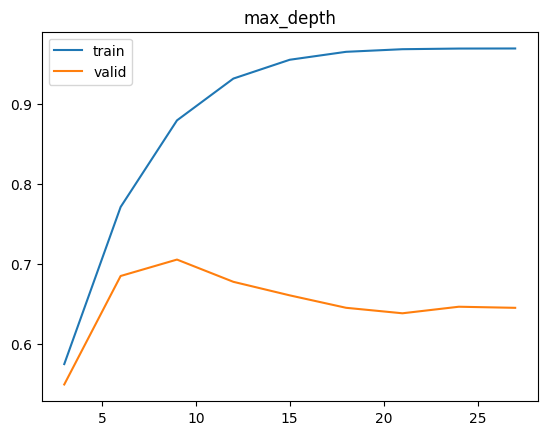

9

In [59]:
params = np.arange(3, 30, 3)
train = []
valid = []

for par in params:
    result = cross_validate(DecisionTreeRegressor(random_state=42,
                                                 max_depth=par), 
                            X_train, y_train, cv=10, scoring = 'r2', return_train_score=True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot(x = params, y = valid, label = 'valid')
plt.title('max_depth')
plt.show()
max_depth_fin = params[np.argmax(valid)]
max_depth_fin

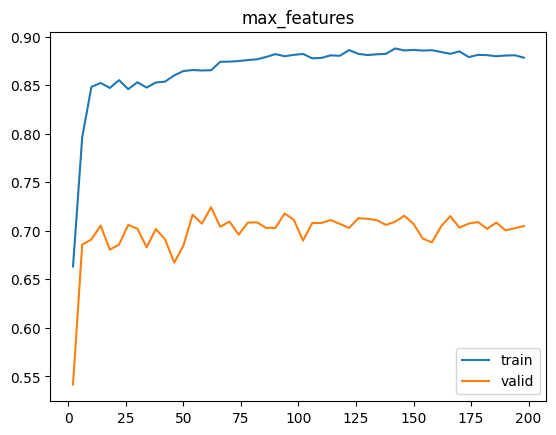

62

In [61]:
params = np.arange(2, 200, 4)
train = []
valid = []

for par in params:
    result = cross_validate(DecisionTreeRegressor(random_state=42,
                                                 max_depth=max_depth_fin, 
                                                 max_features=par), 
                            X_train, y_train, cv=10, scoring = 'r2', return_train_score=True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot(x = params, y = valid, label = 'valid')
plt.title('max_features')
plt.show()
max_ft_fin = params[np.argmax(valid)]
max_ft_fin

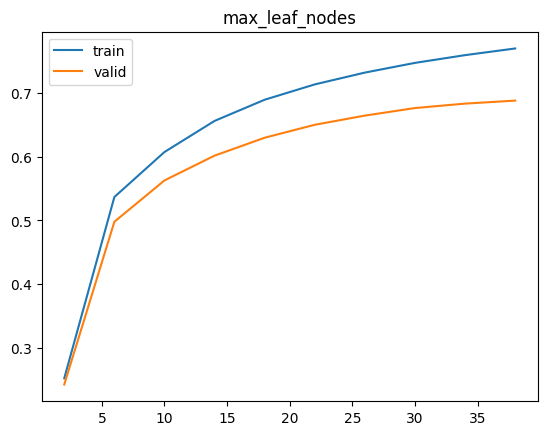

38

In [62]:
params = np.arange(2, 40, 4)
train = []
valid = []

for par in params:
    result = cross_validate(DecisionTreeRegressor(random_state=42,
                                                 max_depth=max_depth_fin, 
                                                 max_features=max_ft_fin, 
                                                 max_leaf_nodes=par), 
                            X_train, y_train, cv=10, scoring = 'r2', return_train_score=True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot(x = params, y = valid, label = 'valid')
plt.title('max_leaf_nodes')
plt.show()
max_leaf_nodes_fin = params[np.argmax(valid)]
max_leaf_nodes_fin

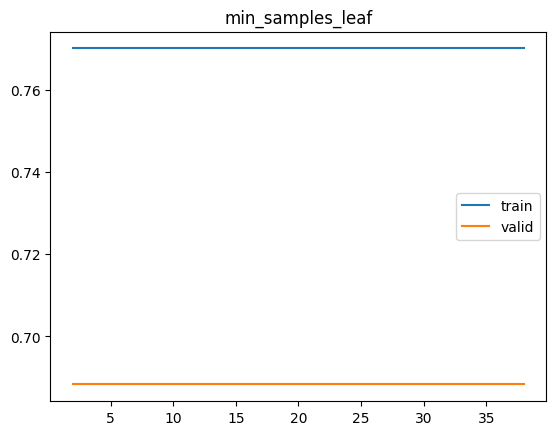

2

In [63]:
params = np.arange(2, 40, 4)
train = []
valid = []

for par in params:
    result = cross_validate(DecisionTreeRegressor(random_state=42,
                                                 max_depth=max_depth_fin, 
                                                 max_features=max_ft_fin, 
                                                 max_leaf_nodes=max_leaf_nodes_fin), 
                            X_train, y_train, cv=10, scoring = 'r2', return_train_score=True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot(x = params, y = valid, label = 'valid')
plt.title('min_samples_leaf')
plt.show()
min_samples_leaf_fin = params[np.argmax(valid)]
min_samples_leaf_fin

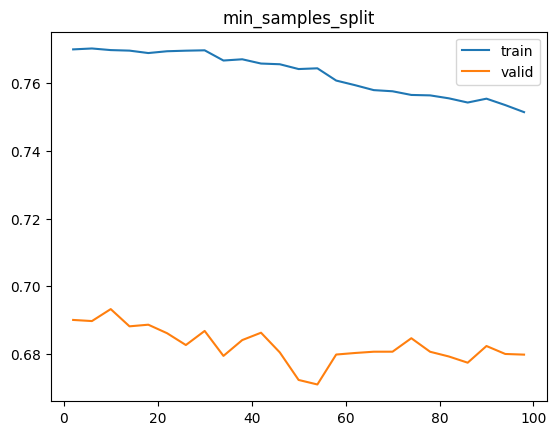

10

In [64]:
params = np.arange(2, 100, 4)
train = []
valid = []

for par in params:
    result = cross_validate(DecisionTreeRegressor(random_state=42,
                                                 max_depth=max_depth_fin, 
                                                 max_features=max_ft_fin, 
                                                 max_leaf_nodes=max_leaf_nodes_fin, 
                                                 min_samples_leaf=min_samples_leaf_fin,
                                                 min_samples_split=par), 
                            X_train, y_train, cv=10, scoring = 'r2', return_train_score=True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot(x = params, y = valid, label = 'valid')
plt.title('min_samples_split')
plt.show()
min_samples_split_fin = params[np.argmax(valid)]
min_samples_split_fin

In [65]:
#model tree regressor optimized
tree_reg_opt = DecisionTreeRegressor(max_depth=max_depth_fin, max_features=max_ft_fin, max_leaf_nodes=max_leaf_nodes_fin,
min_samples_leaf=min_samples_leaf_fin, min_samples_split=min_samples_split_fin)

In [66]:
def calculate_metrics_dtreg(x, y, estimator):
    from sklearn.metrics import r2_score, mean_squared_error
    import pandas as pd
    import numpy as np
    performance = {'r2': [], 'rmse': []}
    # for n in kneighbors:
        # estimator.set_params(n_neighbors=n)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(x)
    performance['r2'] += [r2_score(y, y_pred)]
    performance['rmse'] += [mean_squared_error(y, y_pred) ** (1/2)]
        # performance['label'] += [f"n_{n}"]
    
    perf_df = pd.DataFrame(performance)
    # perf_df.set_index('label', inplace=True)
    return perf_df

In [67]:
calculate_metrics_dtreg(X_test, y_test, tree_reg_opt)

,r2,rmse
0,0.6972,0.966517


### Random Forest

In [68]:
from sklearn.ensemble import RandomForestRegressor

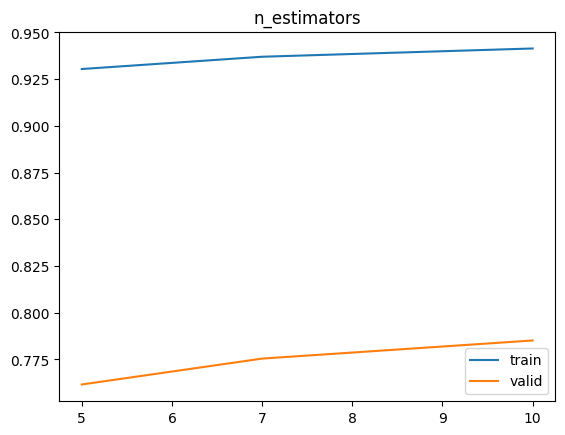

10

In [69]:
params = [5, 7, 10]
train = []
valid = []

for par in params:
    result = cross_validate(RandomForestRegressor(random_state=42,
                                                 n_estimators=par), 
                            X_train, y_train, cv=10, scoring = 'r2', return_train_score=True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot(x = params, y = valid, label = 'valid')
plt.title('n_estimators')
plt.show()
n_estimators_fin = params[np.argmax(valid)]
n_estimators_fin

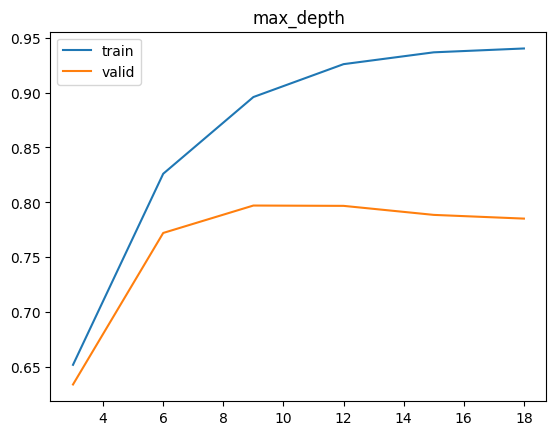

9

In [70]:
params = np.arange(3, 21, 3)
train = []
valid = []

for par in params:
    result = cross_validate(RandomForestRegressor(random_state=42,
                                                 n_estimators=n_estimators_fin, max_depth=par), 
                            X_train, y_train, cv=10, scoring = 'r2', return_train_score=True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot(x = params, y = valid, label = 'valid')
plt.title('max_depth')
plt.show()
max_depth_fin = params[np.argmax(valid)]
max_depth_fin

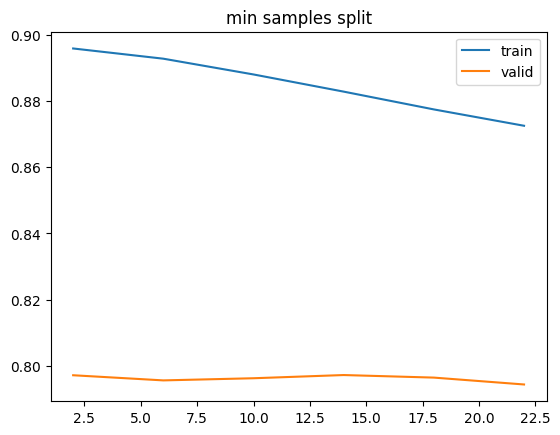

14

In [71]:
params = np.arange(2, 24, 4)
train = []
valid = []

for par in params:
    result = cross_validate(RandomForestRegressor(random_state=42,
                                                 n_estimators=n_estimators_fin, max_depth=max_depth_fin, 
                                                 min_samples_split=par), 
                            X_train, y_train, cv=10, scoring = 'r2', return_train_score=True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot(x = params, y = valid, label = 'valid')
plt.title('min samples split')
plt.show()
min_samples_split_fin = params[np.argmax(valid)]
min_samples_split_fin

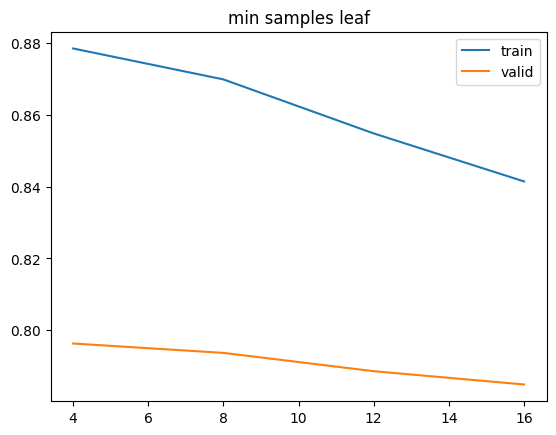

4

In [72]:
params = np.arange(4, 20, 4)
train = []
valid = []

for par in params:
    result = cross_validate(RandomForestRegressor(random_state=42,
                                                 n_estimators=n_estimators_fin, max_depth=max_depth_fin, 
                                                 min_samples_split=min_samples_split_fin, min_samples_leaf=par), 
                            X_train, y_train, cv=10, scoring = 'r2', return_train_score=True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot(x = params, y = valid, label = 'valid')
plt.title('min samples leaf')
plt.show()
min_samples_leaf_fin = params[np.argmax(valid)]
min_samples_leaf_fin

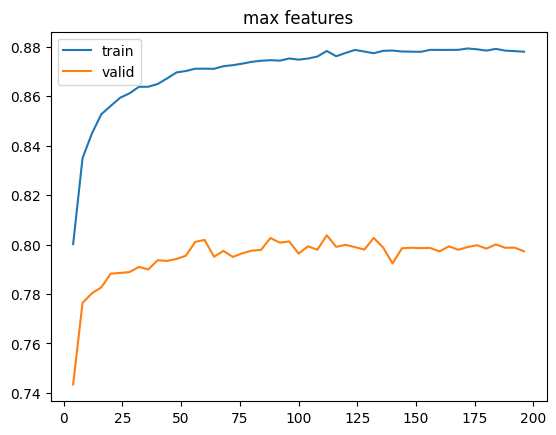

112

In [73]:
params = np.arange(4, 200, 4)
train = []
valid = []

for par in params:
    result = cross_validate(RandomForestRegressor(random_state=42,
                                                 n_estimators=n_estimators_fin, max_depth=max_depth_fin, 
                                                 min_samples_split=min_samples_split_fin, min_samples_leaf=min_samples_leaf_fin,
                                                 max_features=par), 
                            X_train, y_train, cv=10, scoring = 'r2', return_train_score=True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot(x = params, y = valid, label = 'valid')
plt.title('max features')
plt.show()
max_features_fin = params[np.argmax(valid)]
max_features_fin

In [74]:
rfreg_opt = RandomForestRegressor(random_state=42, n_estimators=n_estimators_fin, max_depth=max_depth_fin, min_samples_split=min_samples_split_fin,
                              min_samples_leaf=min_samples_leaf_fin, max_features=max_features_fin)

In [75]:
def calculate_metrics_rfreg(x, y, estimator):
    from sklearn.metrics import r2_score, mean_squared_error
    import pandas as pd
    import numpy as np
    performance = {'r2': [], 'rmse': []}
    # for n in kneighbors:
        # estimator.set_params(n_neighbors=n)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(x)
    performance['r2'] += [r2_score(y, y_pred)]
    performance['rmse'] += [mean_squared_error(y, y_pred) ** (1/2)]
        # performance['label'] += [f"n_{n}"]
    
    perf_df = pd.DataFrame(performance)
    # perf_df.set_index('label', inplace=True)
    return perf_df

In [76]:
calculate_metrics_rfreg(X_test, y_test, rfreg_opt)

,r2,rmse
0,0.766373,0.848972


### AdaBoost

In [77]:
from sklearn.ensemble import AdaBoostRegressor

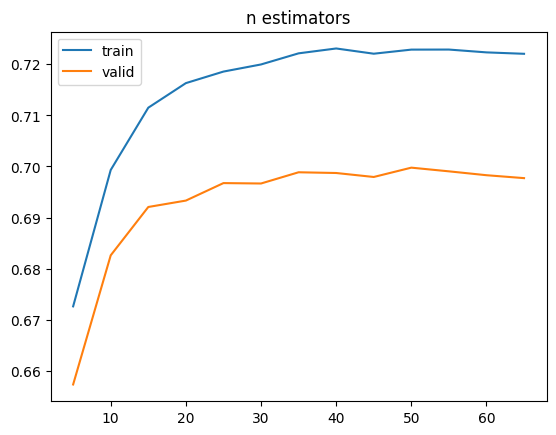

50

In [94]:
params = np.arange(5, 70, 5)
train = []
valid = []

for par in params:
    result = cross_validate(AdaBoostRegressor(random_state=42,
                                                 n_estimators=par), 
                            X_train, y_train, cv=10, scoring = 'r2', return_train_score=True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot(x = params, y = valid, label = 'valid')
plt.title('n estimators')
plt.show()
n_estimators_fin = params[np.argmax(valid)]
n_estimators_fin

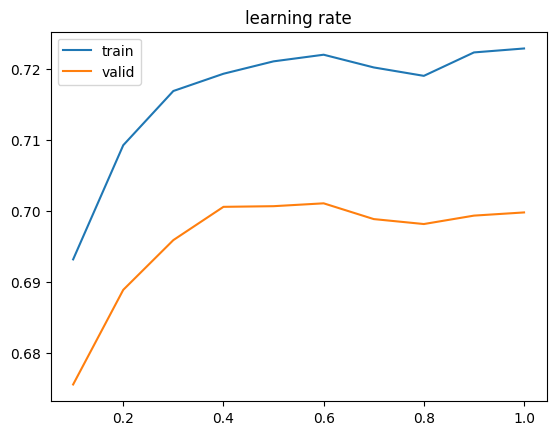

0.6

In [95]:
params = np.arange(0.1, 1.1, 0.1)
train = []
valid = []

for par in params:
    result = cross_validate(AdaBoostRegressor(random_state=42,
                                                 n_estimators=n_estimators_fin, learning_rate=par), 
                            X_train, y_train, cv=10, scoring = 'r2', return_train_score=True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot(x = params, y = valid, label = 'valid')
plt.title('learning rate')
plt.show()
learning_rate_fin = params[np.argmax(valid)]
learning_rate_fin

In [96]:
adaboost_opt = AdaBoostRegressor(random_state=42, learning_rate=learning_rate_fin, n_estimators=n_estimators_fin)

In [97]:
def calculate_metrics_adaboost(x, y, estimator):
    from sklearn.metrics import r2_score, mean_squared_error
    import pandas as pd
    import numpy as np
    performance = {'r2': [], 'rmse': []}
    # for n in kneighbors:
        # estimator.set_params(n_neighbors=n)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(x)
    performance['r2'] += [r2_score(y, y_pred)]
    performance['rmse'] += [mean_squared_error(y, y_pred) ** (1/2)]
        # performance['label'] += [f"n_{n}"]
    
    perf_df = pd.DataFrame(performance)
    # perf_df.set_index('label', inplace=True)
    return perf_df

In [98]:
calculate_metrics_adaboost(X_test, y_test, adaboost_opt)

,r2,rmse
0,0.67484,1.001569


### XGBoost

In [99]:
from xgboost import XGBRegressor

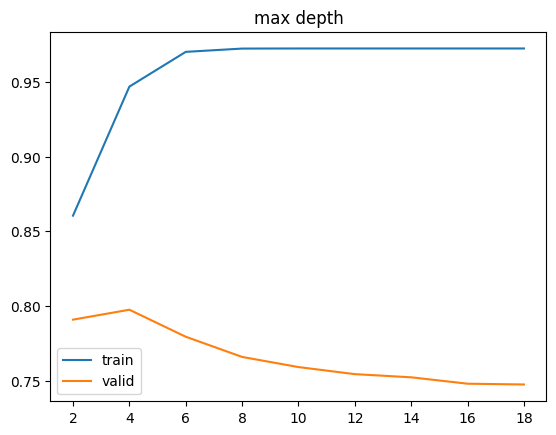

4

In [110]:
params = np.arange(2, 20, 2)
train = []
valid = []

for par in params:
    result = cross_validate(XGBRegressor(max_depth=par), 
                            X_train, y_train, cv=5, scoring = 'r2', return_train_score=True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot(x = params, y = valid, label = 'valid')
plt.title('max depth')
plt.show()
max_depth_fin = params[np.argmax(valid)]
max_depth_fin

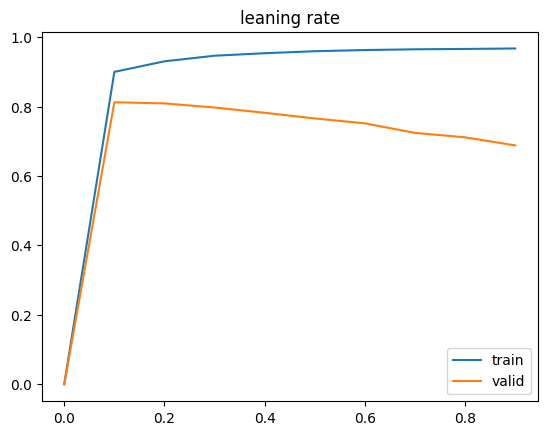

0.1

In [111]:
params = np.arange(0, 1, 0.1)
train = []
valid = []

for par in params:
    result = cross_validate(XGBRegressor(max_depth=max_depth_fin, learning_rate=par), 
                            X_train, y_train, cv=5, scoring = 'r2', return_train_score=True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot(x = params, y = valid, label = 'valid')
plt.title('leaning rate')
plt.show()
learning_rate_fin = params[np.argmax(valid)]
learning_rate_fin

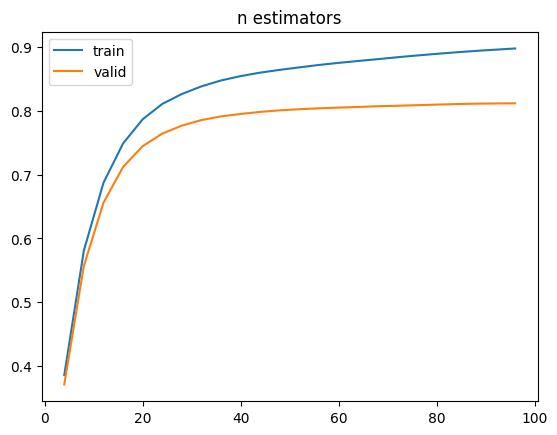

96

In [102]:
params = np.arange(4, 100, 4)
train = []
valid = []

for par in params:
    result = cross_validate(XGBRegressor(max_depth=max_depth_fin, learning_rate=learning_rate_fin, n_estimators=par), 
                            X_train, y_train, cv=5, scoring = 'r2', return_train_score=True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot(x = params, y = valid, label = 'valid')
plt.title('n estimators')
plt.show()
n_estimators_fin = params[np.argmax(valid)]
n_estimators_fin

In [112]:
xgbreg_opt = XGBRegressor(max_depth=max_depth_fin, learning_rate=learning_rate_fin, n_estimators=50)

In [113]:
def calculate_metrics_xgbreg(x, y, estimator):
    from sklearn.metrics import r2_score, mean_squared_error
    import pandas as pd
    import numpy as np
    performance = {'r2': [], 'rmse': []}
    # for n in kneighbors:
        # estimator.set_params(n_neighbors=n)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(x)
    performance['r2'] += [r2_score(y, y_pred)]
    performance['rmse'] += [mean_squared_error(y, y_pred) ** (1/2)]
        # performance['label'] += [f"n_{n}"]
    
    perf_df = pd.DataFrame(performance)
    # perf_df.set_index('label', inplace=True)
    return perf_df

In [114]:
calculate_metrics_xgbreg(X_test, y_test, xgbreg_opt)

,r2,rmse
0,0.779564,0.824657


### Histogram Gradient Boosting

In [115]:
from sklearn.ensemble import HistGradientBoostingRegressor

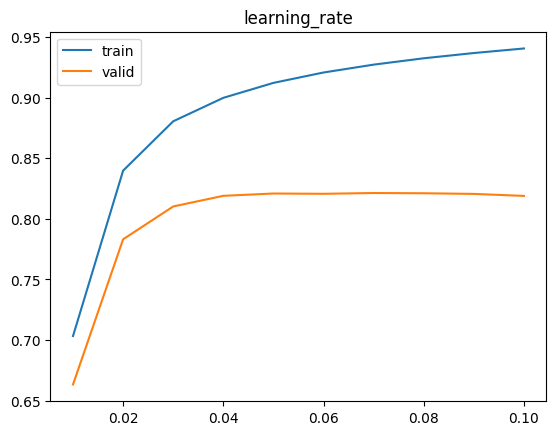

0.06999999999999999

In [116]:
params = np.arange(0.01, 0.11, 0.01)
train = []
valid = []

for par in params:
    result = cross_validate(HistGradientBoostingRegressor(random_state=42, learning_rate=par),
                            X_train, y_train, cv=10, scoring = 'r2', return_train_score=True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot(x = params, y = valid, label = 'valid')
plt.title('learning_rate')
plt.show()
learning_rate_fin = params[np.argmax(valid)]
learning_rate_fin

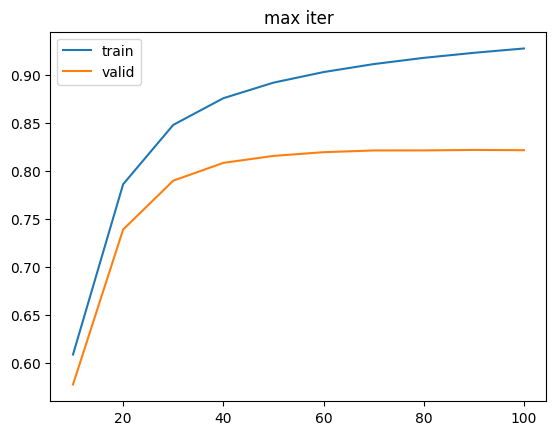

90

In [117]:
params = np.arange(10, 110, 10)
train = []
valid = []

for par in params:
    result = cross_validate(HistGradientBoostingRegressor(random_state=42, learning_rate=learning_rate_fin, max_iter=par),
                            X_train, y_train, cv=10, scoring = 'r2', return_train_score=True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot(x = params, y = valid, label = 'valid')
plt.title('max iter')
plt.show()
max_iter_fin = params[np.argmax(valid)]
max_iter_fin

In [118]:
max_iter_fin = 60

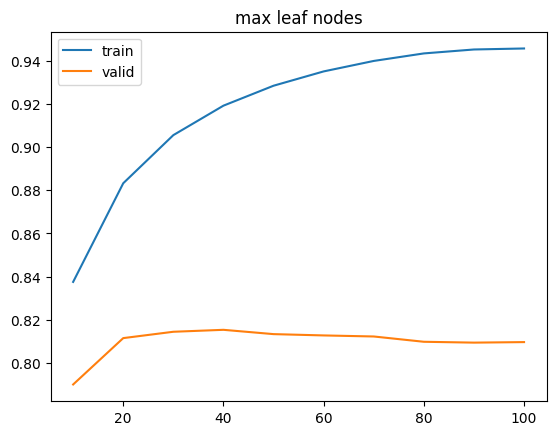

40

In [119]:
params = np.arange(10, 110, 10)
train = []
valid = []

for par in params:
    result = cross_validate(HistGradientBoostingRegressor(random_state=42, learning_rate=learning_rate_fin, max_iter=max_iter_fin,
                                                        max_leaf_nodes=par),
                            X_train, y_train, cv=5, scoring = 'r2', return_train_score=True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())

sns.lineplot(x = params, y = train, label = 'train')
sns.lineplot(x = params, y = valid, label = 'valid')
plt.title('max leaf nodes')
plt.show()
max_leaf_nodes_fin = params[np.argmax(valid)]
max_leaf_nodes_fin

In [120]:
def optimize_parameters(model, X, y, params:dict, range_from_to_step:list[int], parameter_to_optimize:str, 
                        scoring_method='r2', nfolds:int=5) -> dict:
    # return optimzed parameters
    # plot optimization process
    
    train = []
    valid = []

    for par in range_from_to_step:
        params[parameter_to_optimize] = par
        result = cross_validate(model(**params),
                                X=X, y=y, cv=nfolds, scoring = scoring_method, return_train_score=True)
        train.append(result['train_score'].mean())
        valid.append(result['test_score'].mean())

    sns.lineplot(x = range_from_to_step, y = train, label = 'train')
    sns.lineplot(x = range_from_to_step, y = valid, label = 'valid')
    plt.title(parameter_to_optimize)
    plt.show()
    params[parameter_to_optimize] = range_from_to_step[np.argmax(valid)]
    print(params)
    return params

In [121]:
pars = {'random_state': 42, 'learning_rate':learning_rate_fin, 'max_iter': max_iter_fin, 'max_leaf_nodes': max_leaf_nodes_fin}

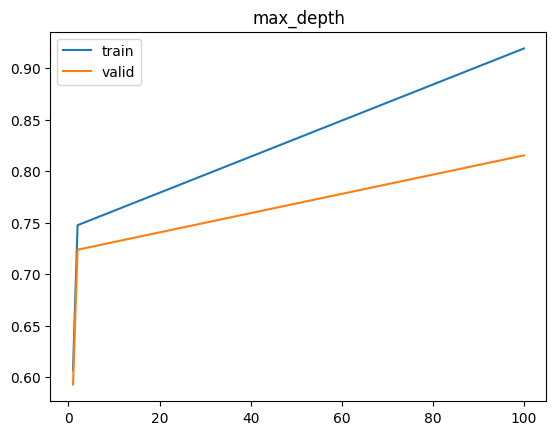

{'random_state': 42, 'learning_rate': 0.06999999999999999, 'max_iter': 60, 'max_leaf_nodes': 40, 'max_depth': 100}


In [122]:
params = optimize_parameters(HistGradientBoostingRegressor, X_train, y_train, pars, [1, 100, 2], 'max_depth')

In [123]:
params['max_depth'] = 50
params

{'random_state': 42,
 'learning_rate': 0.06999999999999999,
 'max_iter': 60,
 'max_leaf_nodes': 40,
 'max_depth': 50}

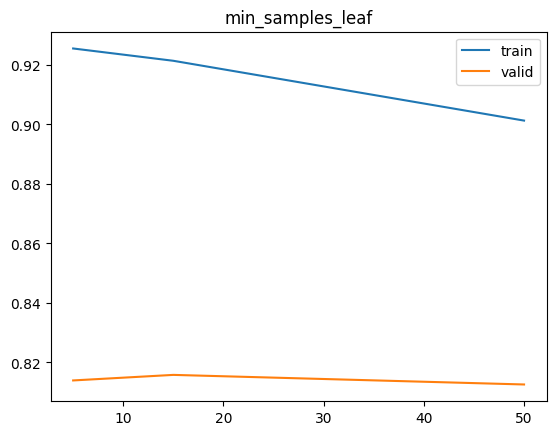

{'random_state': 42, 'learning_rate': 0.06999999999999999, 'max_iter': 60, 'max_leaf_nodes': 40, 'max_depth': 50, 'min_samples_leaf': 15}


In [124]:
params = optimize_parameters(HistGradientBoostingRegressor, X_train, y_train, params, [15, 50, 5], 'min_samples_leaf')

In [125]:
def calculate_metrics(x, y, estimator):
    from sklearn.metrics import r2_score, mean_squared_error
    import pandas as pd
    import numpy as np
    performance = {'r2': [], 'rmse': []}
    
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(x)
    performance['r2'] += [r2_score(y, y_pred)]
    performance['rmse'] += [mean_squared_error(y, y_pred) ** (1/2)]
    
    perf_df = pd.DataFrame(performance)
    return perf_df

In [126]:
hgboost_opt = HistGradientBoostingRegressor(**params)
calculate_metrics(X_test, y_test, hgboost_opt)

,r2,rmse
0,0.803739,0.778124


### Gradient Boosting Regressor

In [127]:
from sklearn.ensemble import GradientBoostingRegressor

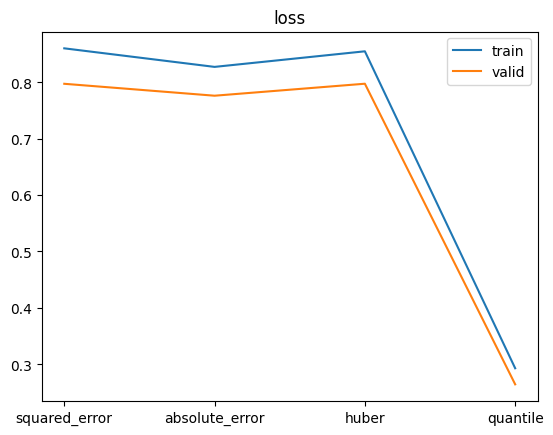

{'loss': 'huber'}


In [128]:
loss_functions = ['squared_error', 'absolute_error', 'huber', 'quantile']

gbreg_params = optimize_parameters(
    GradientBoostingRegressor, 
    X_train, 
    y_train, 
    {}, 
    loss_functions, 
    'loss'
    )

In [129]:
gbreg_params['loss'] = 'squared_error'

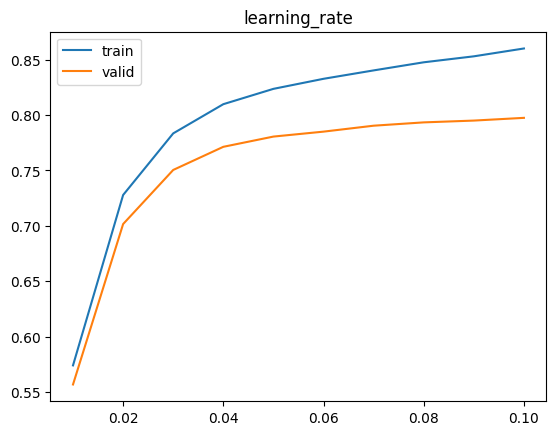

{'loss': 'squared_error', 'learning_rate': 0.09999999999999999}


In [130]:
learning_rates = np.arange(0.01, 0.11, 0.01)

gbreg_params = optimize_parameters(
    GradientBoostingRegressor, 
    X_train, 
    y_train, 
    gbreg_params, 
    learning_rates, 
    'learning_rate'
    )

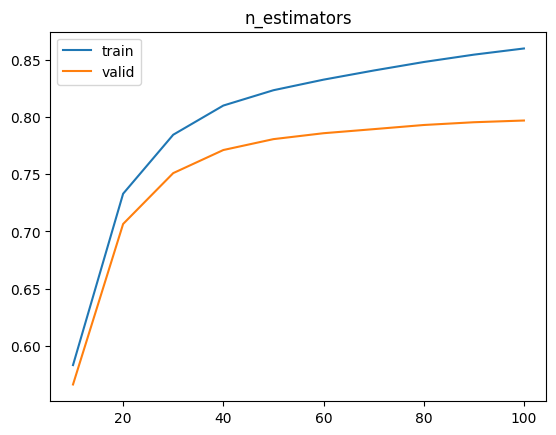

{'loss': 'squared_error', 'learning_rate': 0.09999999999999999, 'n_estimators': 100}


In [131]:
n_estimators = np.arange(10, 110, 10)

gbreg_params = optimize_parameters(
    GradientBoostingRegressor, 
    X_train, 
    y_train, 
    gbreg_params, 
    n_estimators, 
    'n_estimators'
    )

In [132]:
gbreg_params['n_estimators'] = 60

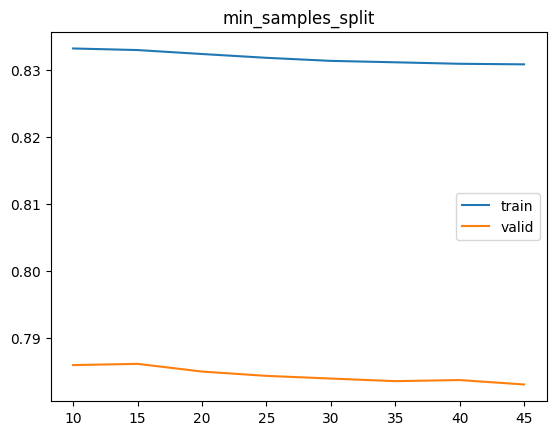

{'loss': 'squared_error', 'learning_rate': 0.09999999999999999, 'n_estimators': 60, 'min_samples_split': 15}


In [133]:
min_samples_splits = np.arange(10, 50, 5)

gbreg_params = optimize_parameters(
    GradientBoostingRegressor, 
    X_train, 
    y_train, 
    gbreg_params, 
    min_samples_splits, 
    'min_samples_split'
    )

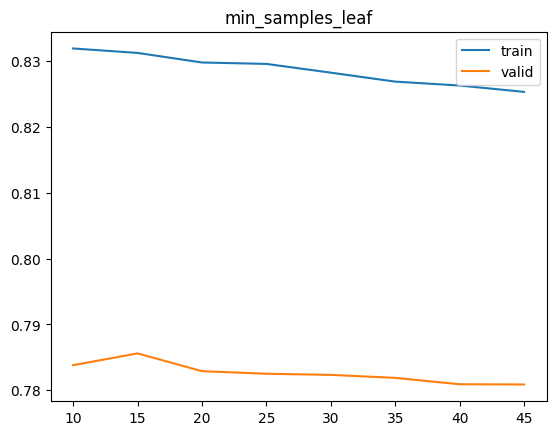

{'loss': 'squared_error', 'learning_rate': 0.09999999999999999, 'n_estimators': 60, 'min_samples_split': 15, 'min_samples_leaf': 15}


In [134]:
min_samples_leafs = np.arange(10, 50, 5)

gbreg_params = optimize_parameters(
    GradientBoostingRegressor, 
    X_train, 
    y_train, 
    gbreg_params, 
    min_samples_leafs, 
    'min_samples_leaf'
    )

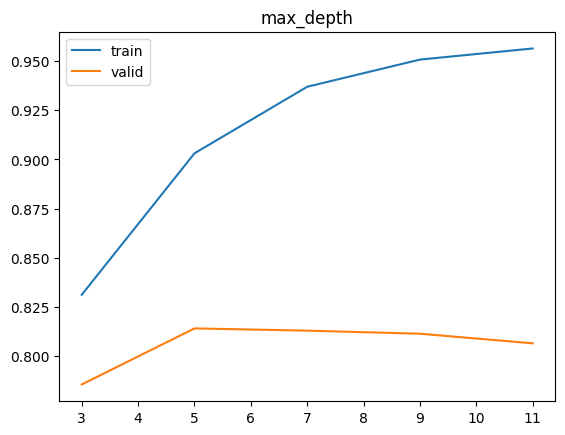

{'loss': 'squared_error', 'learning_rate': 0.09999999999999999, 'n_estimators': 60, 'min_samples_split': 15, 'min_samples_leaf': 15, 'random_state': 42, 'max_depth': 5}


In [136]:
max_depths = np.arange(3, 13, 2)

gbreg_params = optimize_parameters(
    GradientBoostingRegressor, 
    X_train, 
    y_train, 
    gbreg_params, 
    max_depths, 
    'max_depth'
    )

In [137]:
gbreg_params['random_state'] = 42

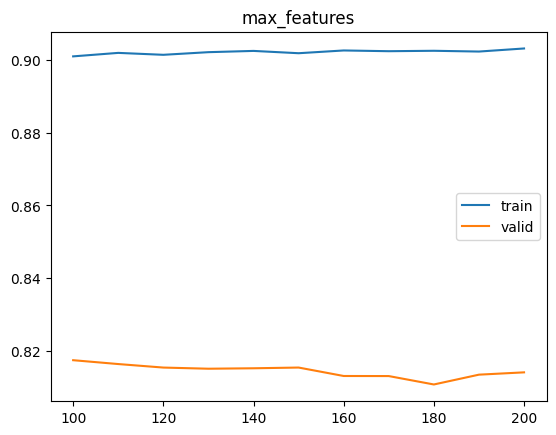

{'loss': 'squared_error', 'learning_rate': 0.09999999999999999, 'n_estimators': 60, 'min_samples_split': 15, 'min_samples_leaf': 15, 'random_state': 42, 'max_depth': 5, 'max_features': 100}


In [138]:
max_features_ls = np.arange(100, 210, 10)

gbreg_params = optimize_parameters(
    GradientBoostingRegressor, 
    X_train, 
    y_train, 
    gbreg_params, 
    max_features_ls, 
    'max_features'
    )

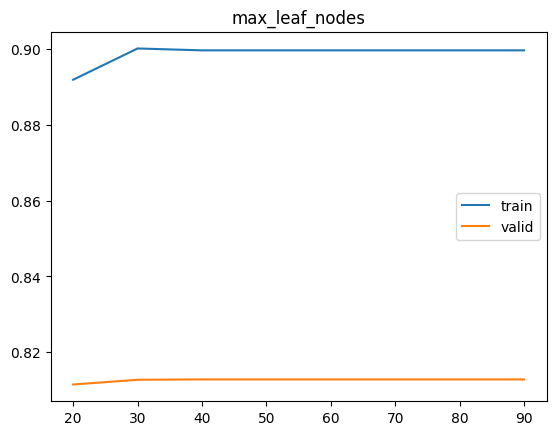

{'loss': 'squared_error', 'learning_rate': 0.09999999999999999, 'n_estimators': 60, 'min_samples_split': 15, 'min_samples_leaf': 15, 'random_state': 42, 'max_depth': 5, 'max_features': 100, 'max_leaf_nodes': 40}


In [139]:
max_leaf_nodes_ls = np.arange(20, 100, 10)

gbreg_params = optimize_parameters(
    GradientBoostingRegressor, 
    X_train, 
    y_train, 
    gbreg_params, 
    max_leaf_nodes_ls, 
    'max_leaf_nodes'
    )

In [140]:
gbreg_opt = GradientBoostingRegressor(**gbreg_params)

In [141]:
calculate_metrics(
    X_test,
    y_test,
    gbreg_opt
)

,r2,rmse
0,0.805275,0.775073


### Multilayer Perceptron

In [142]:
from sklearn.neural_network import MLPRegressor

c:\Users\noviasari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\noviasari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\noviasari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\noviasari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

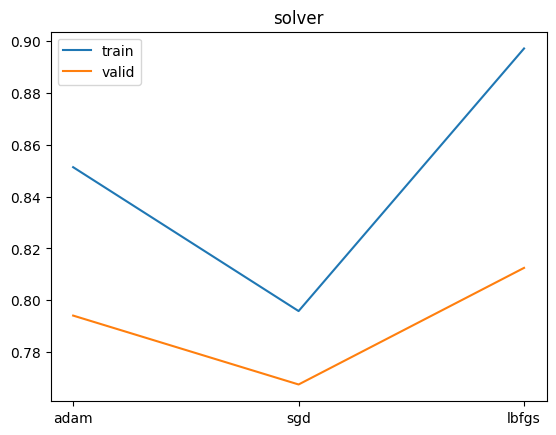

{'solver': 'lbfgs'}


In [143]:
solvers = ['adam', 'sgd', 'lbfgs']
mlp_params = optimize_parameters(
                    MLPRegressor, 
                    X_train, 
                    y_train, 
                    {},
                    solvers,
                    'solver'
                    )

In [144]:
# choose solver 'adam' instead of 'lbfgs' despite the highest r2 score
# solver 'lbfgs' indicates overfitting due to high gap between validation and training process
mlp_params['solver'] = 'adam'

c:\Users\noviasari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\noviasari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\noviasari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\noviasari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

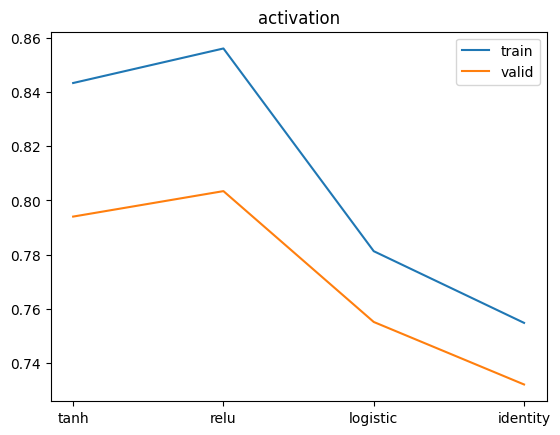

{'solver': 'adam', 'activation': 'relu'}


In [145]:
identities = ['tanh', 'relu', 'logistic', 'identity']
mlp_params = optimize_parameters(
    MLPRegressor,
    X_train,
    y_train,
    mlp_params,
    identities,
    'activation'
)

c:\Users\noviasari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\noviasari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\noviasari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\noviasari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

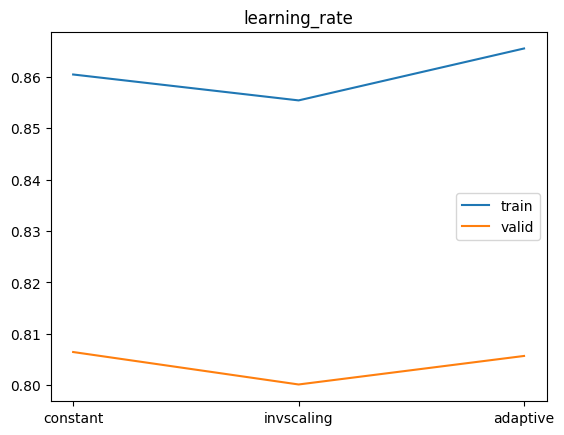

{'solver': 'adam', 'activation': 'relu', 'learning_rate': 'constant'}


In [146]:
learning_rates = ['constant', 'invscaling', 'adaptive']
mlp_params = optimize_parameters(
    MLPRegressor,
    X_train,
    y_train,
    mlp_params,
    learning_rates,
    'learning_rate'
)

In [147]:
mlp_opt = MLPRegressor(**mlp_params)
calculate_metrics(X_test, y_test, mlp_opt)

c:\Users\noviasari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,r2,rmse
0,0.762064,0.856765


### Stochastic Gradient Descent

In [148]:
from sklearn.linear_model import SGDRegressor

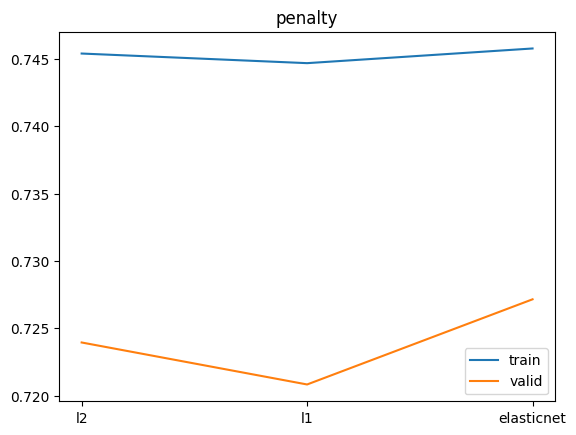

{'penalty': 'elasticnet'}


In [149]:
penalties = ['l2', 'l1', 'elasticnet']
sgd_params = optimize_parameters(
    SGDRegressor,
    X_train,
    y_train,
    {},
    penalties,
    'penalty'
    )

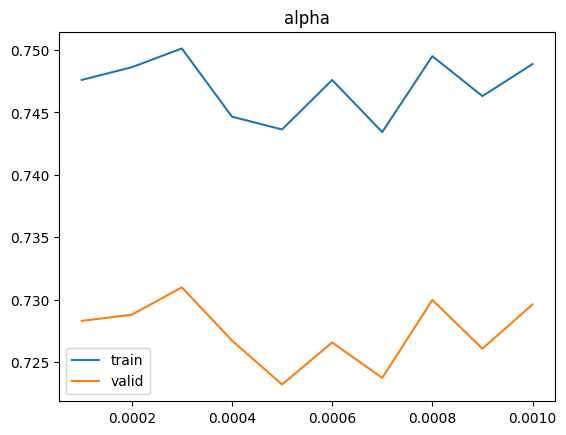

{'penalty': 'elasticnet', 'alpha': 0.00030000000000000003}


In [150]:
alphas = np.arange(0.0001, 0.0011, 0.0001)
sgd_params = optimize_parameters(
    SGDRegressor,
    X_train,
    y_train,
    sgd_params,
    alphas,
    'alpha'
    )

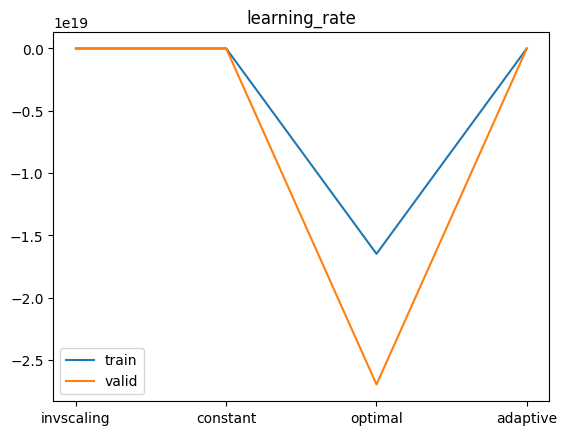

{'penalty': 'elasticnet', 'alpha': 0.00030000000000000003, 'learning_rate': 'adaptive'}


In [151]:
learning_rates = ['invscaling', 'constant', 'optimal', 'adaptive']
sgd_params = optimize_parameters(
    SGDRegressor,
    X_train,
    y_train,
    sgd_params,
    learning_rates,
    'learning_rate'
)

In [152]:
sgd_opt = SGDRegressor(**sgd_params)
calculate_metrics(X_test, y_test, sgd_opt)

,r2,rmse
0,0.706978,0.950784
